In [2]:
# Importing the relevant packages
import tensorflow as tf
import tensorflow_datasets as tfds

2023-04-16 13:31:18.962473: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 13:31:19.003701: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 13:31:19.004174: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 13:31:19.598691: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/user01/miniconda3/envs/lab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Downloading and preprocessing the data

In [3]:
# Before continuing with our model and training, our first job is to preprocess the dataset
# This is a very important step in all of machine learning

# The MNIST dataset is, in general, highly processed already - after all its 28x28 grayscale images of clearly visible digits
# Thus, our preprocessing will be limited to scaling the pixel values, shuffling the data and creating a validation set

# NOTE: When finally deploying a model in practice, it might be a good idea to include the prerpocessing as initial layers
# In that way, the users could just plug the data (images) directly, instead of being required to resize/rescale it before

In [4]:
# Defining some constants/hyperparameters
BUFFER_SIZE = 70_000 # for reshuffling
BATCH_SIZE = 128
NUM_EPOCHS = 20

In [5]:
# Downloading the MNIST dataset

# When 'with_info' is set to True, tfds.load() returns two variables: 
# - the dataset (including the train and test sets) 
# - meta info regarding the dataset itself

mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

2023-04-16 13:31:20.450543: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-16 13:31:20.450980: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
# Extracting the train and test datasets
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

In [7]:
# Creating a function to scale our image data (it is recommended to scale the pixel values in the range [0,1] )
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.

    return image, label

In [8]:
# Scaling the data
train_and_validation_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

In [9]:
# Defining the size of the validation set
num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

In [10]:
# Defining the size of the test set
num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

In [11]:
# Reshuffling the dataset
train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE)

In [12]:
# Splitting the dataset into training + validation
train_data = train_and_validation_data.skip(num_validation_samples)
validation_data = train_and_validation_data.take(num_validation_samples)

In [13]:
# Batching the data
# NOTE: For proper functioning of the model, we need to create one big batch for the validation and test sets
train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples) 
test_data = test_data.batch(num_test_samples)

## Creating the model and training it

In [14]:
# Now that we have preprocessed the dataset, we can define our CNN and train it

In [15]:
# Outlining the model/architecture of our CNN
# CONV -> MAXPOOL -> CONV -> MAXPOOL -> FLATTEN -> DENSE
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50, 5, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    # (2,2) is the default pool size so we could have just used MaxPooling2D() with no explicit arguments
    tf.keras.layers.Conv2D(50, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10) # You can apply softmax activation here, see below for comentary
])

In [16]:
# A brief summary of the model and parameters
model.summary(line_length = 75)

Model: "sequential"
___________________________________________________________________________
 Layer (type)                    Output Shape                  Param #     
 conv2d (Conv2D)                 (None, 24, 24, 50)            1300        
                                                                           
 max_pooling2d (MaxPooling2D)    (None, 12, 12, 50)            0           
                                                                           
 conv2d_1 (Conv2D)               (None, 10, 10, 50)            22550       
                                                                           
 max_pooling2d_1 (MaxPooling2D)  (None, 5, 5, 50)              0           
                                                                           
 flatten (Flatten)               (None, 1250)                  0           
                                                                           
 dense (Dense)                   (None, 10)                    12510

In [17]:
# Defining the loss function

# In general, our model needs to output probabilities of each class, 
# which can be achieved with a softmax activation in the last dense layer

# However, when using the softmax activation, the loss can rarely be unstable

# Thus, instead of incorporating the softmax into the model itself,
# we use a loss calculation that automatically corrects for the missing softmax

# That is the reason for 'from_logits=True'
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [18]:
# Compiling the model with Adam optimizer and the cathegorical crossentropy as a loss function
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [19]:
# Defining early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',    
    min_delta = 0,
    patience = 2,
    verbose = 0, 
    restore_best_weights = True
)

In [20]:
# Train the network
model.fit(
    train_data, 
    epochs = NUM_EPOCHS, 
    callbacks = [early_stopping], 
    validation_data = validation_data,
    verbose = 2
)

Epoch 1/20


2023-04-16 13:31:20.740432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-04-16 13:31:20.740977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-04-16 13:31:32.930033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{n

422/422 - 14s - loss: 0.2718 - accuracy: 0.9241 - val_loss: 0.0883 - val_accuracy: 0.9730 - 14s/epoch - 32ms/step
Epoch 2/20
422/422 - 12s - loss: 0.0736 - accuracy: 0.9779 - val_loss: 0.0540 - val_accuracy: 0.9873 - 12s/epoch - 27ms/step
Epoch 3/20
422/422 - 12s - loss: 0.0548 - accuracy: 0.9833 - val_loss: 0.0389 - val_accuracy: 0.9897 - 12s/epoch - 28ms/step
Epoch 4/20
422/422 - 12s - loss: 0.0434 - accuracy: 0.9867 - val_loss: 0.0388 - val_accuracy: 0.9878 - 12s/epoch - 28ms/step
Epoch 5/20
422/422 - 12s - loss: 0.0374 - accuracy: 0.9879 - val_loss: 0.0341 - val_accuracy: 0.9900 - 12s/epoch - 28ms/step
Epoch 6/20
422/422 - 12s - loss: 0.0300 - accuracy: 0.9912 - val_loss: 0.0236 - val_accuracy: 0.9918 - 12s/epoch - 28ms/step
Epoch 7/20
422/422 - 12s - loss: 0.0285 - accuracy: 0.9911 - val_loss: 0.0295 - val_accuracy: 0.9908 - 12s/epoch - 28ms/step
Epoch 8/20
422/422 - 12s - loss: 0.0244 - accuracy: 0.9926 - val_loss: 0.0168 - val_accuracy: 0.9933 - 12s/epoch - 28ms/step
Epoch 9/20


## Testing our model

In [21]:
# Testing our model
test_loss, test_accuracy = model.evaluate(test_data)

2023-04-16 13:33:31.963064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-04-16 13:33:31.963539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 674ms/step - loss: 0.0280 - accuracy: 0.9905


In [22]:
# Printing the test results
print('Test loss: {0:.4f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Test loss: 0.0280. Test accuracy: 99.05%


### Plotting images and the results

In [23]:
import matplotlib.pyplot as plt
import numpy as np

In [24]:
# Split the test_data into 2 arrays, containing the images and the corresponding labels
for images, labels in test_data.take(1):
    images_test = images.numpy()
    labels_test = labels.numpy()

# Reshape the images into 28x28 form, suitable for matplotlib (original dimensions: 28x28x1)
images_plot = np.reshape(images_test, (10000,28,28))

2023-04-16 13:33:33.599201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-04-16 13:33:33.599597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


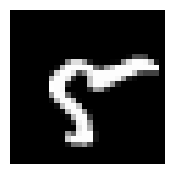

Label: 5


In [25]:
# The image to be displayed and tested
i = 502


# Plot the image
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap="gray", aspect='auto')
plt.show()

# Print the correct label for the image
print("Label: {}".format(labels_test[i-1]))

1/1 [==============================] - 0s 60ms/step


<BarContainer object of 10 artists>

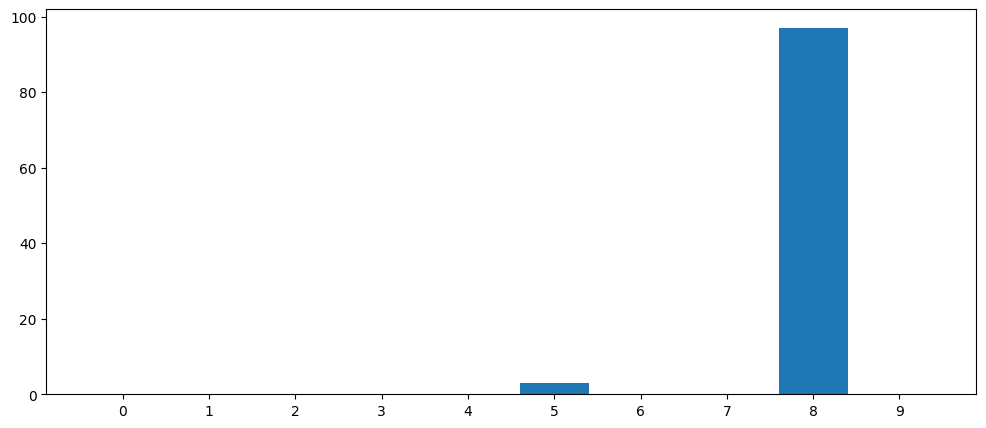

In [26]:
# Obtain the model's predictions (logits)
predictions = model.predict(images_test[i-1:i])

# Convert those predictions into probabilities (recall that we incorporated the softmaxt activation into the loss function)
probabilities = tf.nn.softmax(predictions).numpy()
# Convert the probabilities into percentages
probabilities = probabilities*100


# Create a bar chart to plot the probabilities for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=["0","1","2","3","4","5","6","7","8","9"])